In [59]:
import tensorflow as tf
import os
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

### Загружаем данные датасета


In [60]:
_CIFAR_IMAGE_SIZE = 32
from numpy import loadtxt

def load_data(path, labels_number=1):
  with tf.io.gfile.GFile(path, 'rb') as f:
    data = f.read()
  offset = 0
  max_offset = len(data) - 1
  coarse_labels = []
  fine_labels = []
  images = []
  while offset < max_offset:
    labels = np.frombuffer(
        data, dtype=np.uint8, count=labels_number, offset=offset
    ).reshape((labels_number,))
    # 1 байт под названия, 1024 * 3 = 3072 байтов под изображение.
    offset += labels_number
    img = (
        np.frombuffer(data, dtype=np.uint8, count=3072, offset=offset)
        .reshape((3, _CIFAR_IMAGE_SIZE, _CIFAR_IMAGE_SIZE))
        .transpose((1, 2, 0))
    )
    offset += 3072
    coarse_labels.append(labels[0])
    fine_labels.append(labels[1])
    images.append(img)
  return [np.array(coarse_labels), np.array(fine_labels), np.array(images)]

def load_labels(path):
    return loadtxt(path, comments="#", delimiter=",", unpack=False, dtype='str')

def load_cifar100():
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-binary.tar.gz"
    dataset = tf.keras.utils.get_file("cifar.tar.gz", url,untar=True, cache_dir='.', cache_subdir='')
    dataset_dir = os.path.join(os.path.dirname(dataset), 'cifar-100-binary')
    CY_train, FY_train, X_train = load_data(os.path.join(dataset_dir, 'train.bin'), labels_number=2)
    CY_test, FY_test, X_test = load_data(os.path.join(dataset_dir, 'test.bin'), labels_number=2)
    C_label = load_labels(os.path.join(dataset_dir, 'coarse_label_names.txt'))
    F_label = load_labels(os.path.join(dataset_dir, 'fine_label_names.txt'))
    
    return X_train, CY_train, FY_train, X_test, CY_test, FY_test, C_label, F_label

In [61]:
X_train, CY_train, FY_train, X_test, CY_test, FY_test, C_label, F_label = load_cifar100()

In [62]:
print(X_train.shape,CY_train.shape, FY_train.shape)

(50000, 32, 32, 3) (50000,) (50000,)


In [63]:
# Нормализация значений rgb
X_train, X_test = X_train / 255.0, X_test / 255.0

#### Предпросмотр датасета


In [64]:
def preview_images(classnames, label, images):
    plt.figure(figsize=(12,12))
    for i in range(120):
        plt.subplot(10,12,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classnames[label[i]], labelpad=2, fontsize=6)
    plt.show()

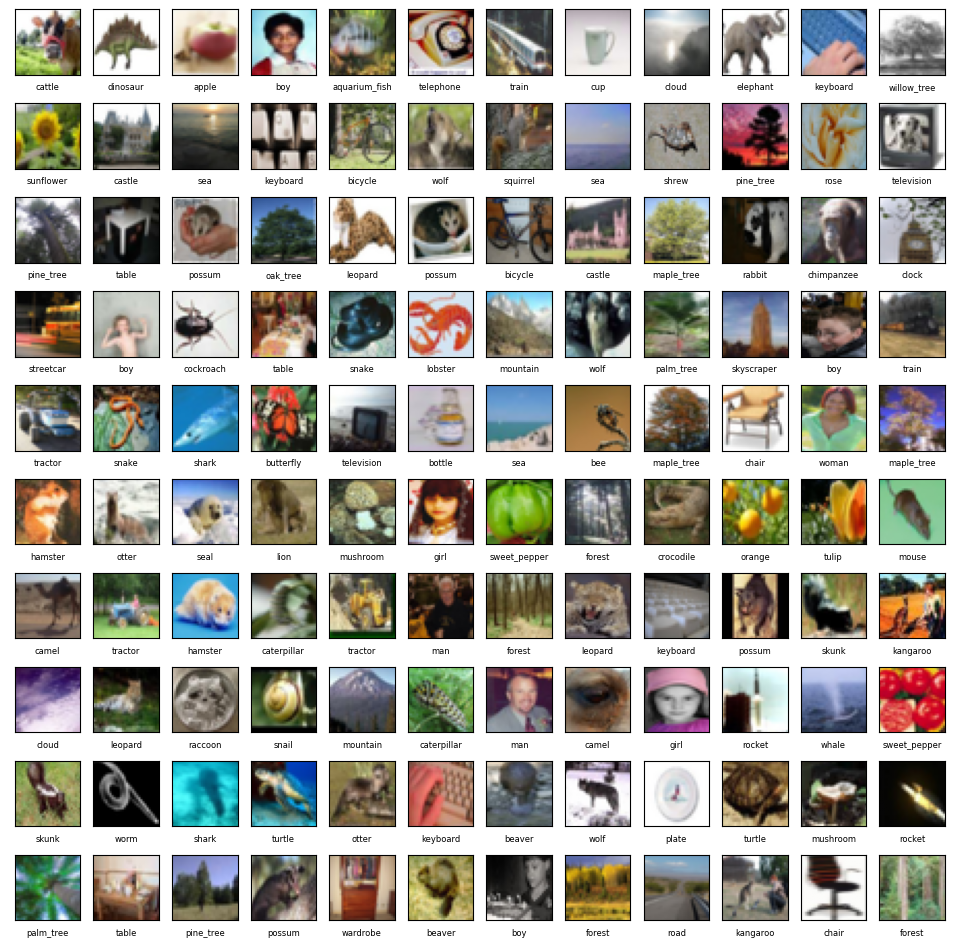

In [65]:
# Вывод изображений с узкими классами
preview_images(F_label, FY_train, X_train)

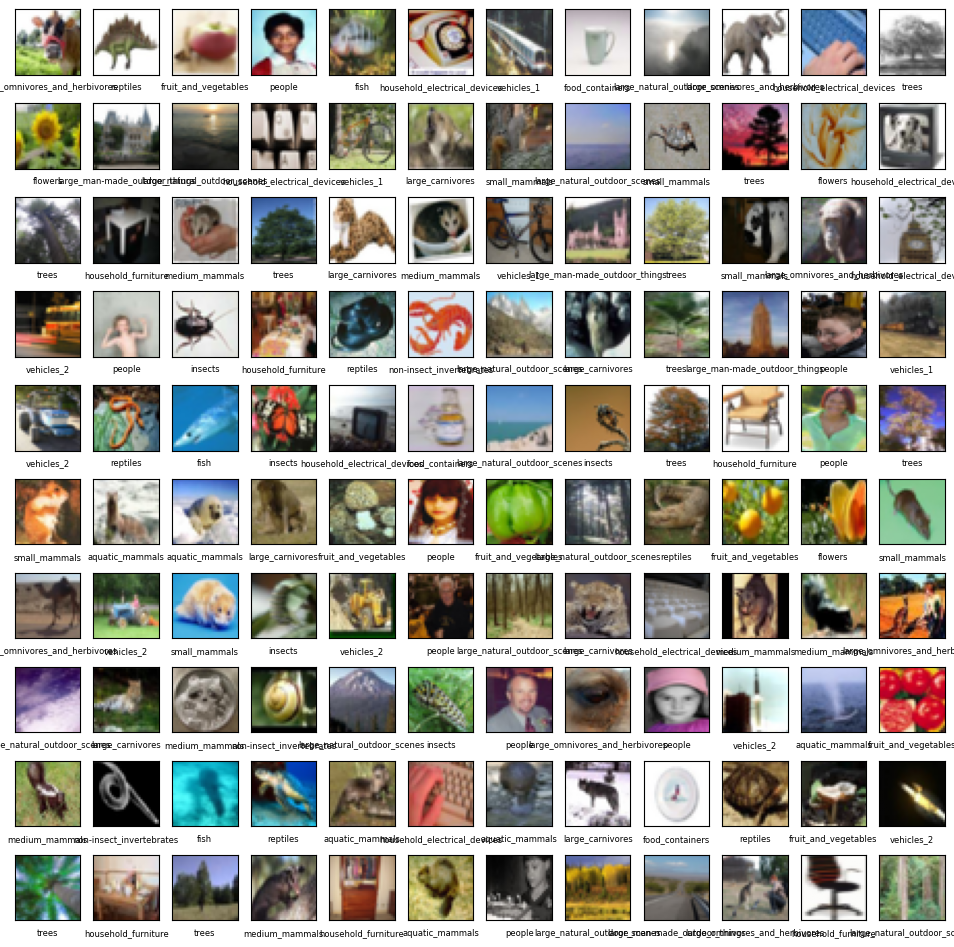

In [66]:
# Вывод изображений с широкими классами
preview_images(C_label, CY_train, X_train)

#### Построение модели


In [67]:

def getModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(100, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [68]:
model = getModel()

### 1 Какие элементы сети зависят от количества цветов, какие — от количества классов?

Архитектура сети зависит от входного слоя, который принимает тензор с размерностью (высота, ширина, количество цветов). В вашем случае, это (32, 32, 3), что соответствует стандартной цветовой глубине RGB изображений.

С другой стороны, количество классов определяет конфигурацию выходного слоя. Так как CIFAR100 включает 100 классов, то последний плотный слой будет содержать 100 выходных нейронов, соответствующих каждому из классов.


### 2 Объяснение места в модели каждого слоя, обоснование выбора гиперпараметров.

В сверточных нейронных сетях промежуточные слои генерируют матрицы изображений или наборы таких матриц. В этих сетях ключевые слои включают сверточные слои, пулинговые слои и полносвязные слои.

Сверточный слой нейронной сети выполняет операцию свертки на выходах предыдущего слоя, где веса ядра свертки настраиваются в процессе обучения. Каждая свертка в слое создает свое собственное изображение на выходе.

Пулинговый слой служит для уменьшения размерности изображения. Он часто использует функции максимума или (взвешенного) среднего для этого. У этого слоя нет настраиваемых параметров.

В одном сверточном слое может быть настроено несколько фильтров. Каждый из этих фильтров создает свое собственное изображение на выходе.

Ядра свертки могут иметь трехмерную структуру, что позволяет моделировать более сложные закономерности в данных.
Применение операции свертки уменьшает размер изображения. Пиксели на границах изображения участвуют в меньшем числе сверток, поэтому используется дополнение изображения (padding) для сохранения размера. Такие свертки называются "одинаковыми" (same convolution), а свертки без дополнения - "правильными" (valid convolution).

Другим параметром сверточного слоя является сдвиг (stride). Он позволяет применять свертку не к каждому пикселю, а только к пикселям с определенным шагом.

Выбор размера ядра свертки является экспериментальным и не должен превышать исходный размер изображения.

|                                                                                                                                                                                                                                                                           |                                                                                                                                                                                                                                                 |                                                       |
| ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------- |
| <td colspan=2> **model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))**                                                                                                                                                                       |
| <td colspan=2> Сверточный 2D-слой. Число выходных фильтров в свертке (размерность выхода) filters W2=32. Высота и ширина окна свертки kernel*size = (F, F) = (3,3). Функция активации = 'relu' *(f(x) = max{0, z})\_. input_shape = (W1, H1, D)                           |
| _Layer (type)_                                                                                                                                                                                                                                                            | _Output Shape_                                                                                                                                                                                                                                  | _Param_                                               |
| conv2d (Conv2D)                                                                                                                                                                                                                                                           | (None, 30, 30, 32)                                                                                                                                                                                                                              | 896                                                   |
|                                                                                                                                                                                                                                                                           | None - кол-во пакетов (единый пакет - None) <br/> 30, 30 = (начальная ширина W1/высота H1 - размер ядра F + 2\*отступ)/шаг + 1 = (32 - 3 +2\*0)/1+1 - итоговая ширина, высота <br/> 32 - число выходных фильтров в свертке (размерность выхода) | 896 = W2 \* (D \* F \* F + 1) = 32 \* (3\*3\*3+1)     |
|                                                                                                                                                                                                                                                                           |                                                                                                                                                                                                                                                 |                                                       |
| <td colspan=2> **model.add(layers.MaxPooling2D((2, 2)))**                                                                                                                                                                                                                 |
| <td colspan=2> Cлой подвыборки, снижающий размерность поступивших на него данных. Размер окна подвыборки pool_size=(2, 2)=(F, F). Шаг подвыборки strides = None, что означает, что strides = pool_size=(2, 2) = S = F.                                                    |
| _Layer (type)_                                                                                                                                                                                                                                                            | _Output Shape_                                                                                                                                                                                                                                  | _Param_                                               |
| max_pooling2d (MaxPooling2D)                                                                                                                                                                                                                                              | (None, 15, 15, 32)                                                                                                                                                                                                                              | 0                                                     |
|                                                                                                                                                                                                                                                                           | None - кол-во пакетов (единый пакет - None) <br/> 15, 15 = (W1/H1 - F)/S+1 = (30 - 2)/2+1 <br/> 32 - число выходных фильтров в свертке (размерность выхода)                                                                                     | 0                                                     |
|                                                                                                                                                                                                                                                                           |                                                                                                                                                                                                                                                 |                                                       |
| <td colspan=2> **model.add(layers.Conv2D(64, (3, 3), activation='relu'))**                                                                                                                                                                                                |
| <td colspan=2> Сверточный 2D-слой. Число выходных фильтров в свертке (размерность выхода) filters W2=64. Высота и ширина окна свертки kernel_size = (F, F) = (3,3). Функция активации = 'relu'. input_shape = (W1=15, H1=15, D=32)                                        |
| _Layer (type)_                                                                                                                                                                                                                                                            | _Output Shape_                                                                                                                                                                                                                                  | _Param_                                               |
| conv2d_1 (Conv2D)                                                                                                                                                                                                                                                         | (None, 13, 13, 64)                                                                                                                                                                                                                              | 18496                                                 |
|                                                                                                                                                                                                                                                                           | None - кол-во пакетов (единый пакет - None) <br/> 13, 13 = (начальная ширина W1/высота H1 - размер ядра F + 2\*отступ)/шаг + 1 = (15 - 3 +2\*0)/1+1 - итоговая ширина, высота <br/> 64 - число выходных фильтров в свертке (размерность выхода) | 18496 = W2 \* (D \* F \* F + 1) = 64 \* (32\*3\*3+1)  |
|                                                                                                                                                                                                                                                                           |                                                                                                                                                                                                                                                 |                                                       |
| <td colspan=2> **model.add(layers.MaxPooling2D((2, 2)))**                                                                                                                                                                                                                 |
| <td colspan=2> Cлой подвыборки, снижающий размерность поступивших на него данных. Размер окна подвыборки pool_size=(2, 2)=(F, F). Шаг подвыборки strides = None, что означает, что strides = pool_size=(2, 2) = S = F.                                                    |
| _Layer (type)_                                                                                                                                                                                                                                                            | _Output Shape_                                                                                                                                                                                                                                  | _Param_                                               |
| max_pooling2d_1 (MaxPooling2D)                                                                                                                                                                                                                                            | (None, 6, 6, 64)                                                                                                                                                                                                                                | 0                                                     |
|                                                                                                                                                                                                                                                                           | None - кол-во пакетов (единый пакет - None) <br/> 6, 6 = (W1/H1 - F)/S+1 = (13 - 2)/2+1 <br/> 64 - число выходных фильтров в свертке (размерность выхода)                                                                                       | 0                                                     |
|                                                                                                                                                                                                                                                                           |                                                                                                                                                                                                                                                 |                                                       |
| <td colspan=2> **model.add(layers.Conv2D(128, (3, 3), activation='relu'))**                                                                                                                                                                                               |
| <td colspan=2> Сверточный 2D-слой. Число выходных фильтров в свертке (размерность выхода) filters W2=128. Высота и ширина окна свертки kernel_size = (F, F) = (3,3). Функция активации = 'relu'. input_shape = (W1=6, H1=6, D=64)                                         |
| _Layer (type)_                                                                                                                                                                                                                                                            | _Output Shape_                                                                                                                                                                                                                                  | _Param_                                               |
| conv2d_2 (Conv2D)                                                                                                                                                                                                                                                         | (None, 4, 4, 128)                                                                                                                                                                                                                               | 73856                                                 |
|                                                                                                                                                                                                                                                                           | None - кол-во пакетов (единый пакет - None) <br/> 4, 4 = (начальная ширина W1/высота H1 - размер ядра F + 2\*отступ)/шаг + 1 = (6 - 3 +2\*0)/1+1 - итоговая ширина, высота <br/> 128 - число выходных фильтров в свертке (размерность выхода)   | 73856 = W2 \* (D \* F \* F + 1) = 128 \* (64\*3\*3+1) |
|                                                                                                                                                                                                                                                                           |                                                                                                                                                                                                                                                 |                                                       |
| <td colspan=2> **model.add(layers.MaxPooling2D((2, 2)))**                                                                                                                                                                                                                 |
| <td colspan=2> Cлой подвыборки, снижающий размерность поступивших на него данных. Размер окна подвыборки pool_size=(2, 2)=(F, F). Шаг подвыборки strides = None, что означает, что strides = pool_size=(2, 2) = S = F.                                                    |
| _Layer (type)_                                                                                                                                                                                                                                                            | _Output Shape_                                                                                                                                                                                                                                  | _Param_                                               |
| max_pooling2d_2 (MaxPooling2D)                                                                                                                                                                                                                                            | (None, 2, 2, 128)                                                                                                                                                                                                                               | 0                                                     |
|                                                                                                                                                                                                                                                                           | None - кол-во пакетов (единый пакет - None) <br/> 2, 2 = (W1/H1 - F)/S+1 = (4 - 2)/2+1 <br/> 128 - число выходных фильтров в свертке (размерность выхода)                                                                                       | 0                                                     |
|                                                                                                                                                                                                                                                                           |                                                                                                                                                                                                                                                 |                                                       |
| <td colspan=2> **model.add(layers.Flatten())**                                                                                                                                                                                                                            |
| <td colspan=2> Cлой слой, преобразующий 2D-данные в 1D-данные.                                                                                                                                                                                                            |
| _Layer (type)_                                                                                                                                                                                                                                                            | _Output Shape_                                                                                                                                                                                                                                  | _Param_                                               |
| flatten (Flatten)                                                                                                                                                                                                                                                         | (None, 512)                                                                                                                                                                                                                                     | 0                                                     |
|                                                                                                                                                                                                                                                                           | None - кол-во пакетов (единый пакет - None) <br/> 512=W1\*H1\*D=2\*2\*128 - одномерные данные                                                                                                                                                   | 0                                                     |
|                                                                                                                                                                                                                                                                           |                                                                                                                                                                                                                                                 |                                                       |
| <td colspan=2> **model.add(layers.Dense(256, activation='relu'))**                                                                                                                                                                                                        |
| <td colspan=2> Полносвязный слой. Размер выхода слоя units = U = 256. W=512 - размер входного слоя. Функция активации = 'relu'.                                                                                                                                           |
| _Layer (type)_                                                                                                                                                                                                                                                            | _Output Shape_                                                                                                                                                                                                                                  | _Param_                                               |
| dense (Dense)                                                                                                                                                                                                                                                             | (None, 256)                                                                                                                                                                                                                                     | 131328                                                |
|                                                                                                                                                                                                                                                                           | None - кол-во пакетов (единый пакет - None) <br/> 256 - размер выхода                                                                                                                                                                           | 131328 = W _ U + U = 512 _ 256 + 256                  |
|                                                                                                                                                                                                                                                                           |                                                                                                                                                                                                                                                 |                                                       |
| <td colspan=2> **model.add(layers.Dense(128, activation='relu'))**                                                                                                                                                                                                        |
| <td colspan=2> Полносвязный слой. Размер выхода слоя units = U = 128. W=256 - размер входного слоя. Функция активации = 'relu'.                                                                                                                                           |
| _Layer (type)_                                                                                                                                                                                                                                                            | _Output Shape_                                                                                                                                                                                                                                  | _Param_                                               |
| dense_1 (Dense)                                                                                                                                                                                                                                                           | (None, 128)                                                                                                                                                                                                                                     | 32896                                                 |
|                                                                                                                                                                                                                                                                           | None - кол-во пакетов (единый пакет - None) <br/> 128 - размер выхода                                                                                                                                                                           | 32896 = W _ U + U = 256 _ 128 + 128                   |
|                                                                                                                                                                                                                                                                           |                                                                                                                                                                                                                                                 |                                                       |
| <td colspan=2> **model.add(layers.Dense(100, activation='softmax'))**                                                                                                                                                                                                     |
| <td colspan=2> Полносвязный слой. Размер выхода слоя units = U = 100. W=128 - размер входного слоя. Функция активации = 'softmax' нормализованная экспоненциальная функция преобразует вектор из действительных чисел в распределение вероятностей возможных результатов. |
| _Layer (type)_                                                                                                                                                                                                                                                            | _Output Shape_                                                                                                                                                                                                                                  | _Param_                                               |
| dense_2 (Dense)                                                                                                                                                                                                                                                           | (None, 100)                                                                                                                                                                                                                                     | 12900                                                 |
|                                                                                                                                                                                                                                                                           | None - кол-во пакетов (единый пакет - None) <br/> 100 - размер выхода                                                                                                                                                                           | 12900 = W _ U + U = 128 _ 100 + 100                   |


Во время компиляции модели применяется функция потерь под названием категориальная перекрестная энтропия (tf.keras.losses.SparseCategoricalCrossentropy). В качестве оптимизатора используется вариант стохастической оптимизации под названием 'adam'. Для оценки эффективности работы модели используется метрика точности ('accuracy').


### 3 Сравнить качество предсказания при обучении на 20 широких классах с предсказаниями при обучении на 100 узких классах,обобщив предсказания по узким меткам до метки их широкого класса в соответствии с таблицей:

#### Обучение на 20 широких классах


In [69]:
model = getModel()

In [70]:
his = model.fit(X_train, CY_train, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 31s 19ms/step - loss: 2.5076 - accuracy: 0.2242
Epoch 2/20
1563/1563 [==============================] - 34s 22ms/step - loss: 2.0657 - accuracy: 0.3584
Epoch 3/20
1563/1563 [==============================] - 44s 28ms/step - loss: 1.8444 - accuracy: 0.4214
Epoch 4/20
1563/1563 [==============================] - 44s 28ms/step - loss: 1.6994 - accuracy: 0.4666
Epoch 5/20
1563/1563 [==============================] - 44s 28ms/step - loss: 1.5961 - accuracy: 0.4967
Epoch 6/20
1563/1563 [==============================] - 44s 28ms/step - loss: 1.4988 - accuracy: 0.5288
Epoch 7/20
1563/1563 [==============================] - 37s 24ms/step - loss: 1.4148 - accuracy: 0.5526
Epoch 8/20
1563/1563 [==============================] - 33s 21ms/step - loss: 1.3346 - accuracy: 0.5775
Epoch 9/20
1563/1563 [==============================] - 36s 23ms/step - loss: 1.2647 - accuracy: 0.5971
Epoch 10/20
1563/1563 [==============================] - 33s 21m

##### Экспорт обученной модели в файл


In [71]:
model.save('./coarse_model.keras')

##### Точность на тестовых данных


In [72]:
С_test_loss, С_test_acc = model.evaluate(X_test, CY_test)

print('\nТочность на тестовых данных:', С_test_acc)

313/313 [==============================] - 6s 16ms/step - loss: 2.0998 - accuracy: 0.4922

Точность на тестовых данных: 0.49219998717308044


##### Предсказания


In [73]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\smallaxe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [74]:
# Получаем набор вероятностей определения каждой категории
С_predictions = model.predict(X_test)

# Находим максимальные вероятности в наборе предсказаний
С_predictions = np.argmax(С_predictions, axis=-1)

# Отображаем оценку модели
print(classification_report(CY_test, С_predictions, target_names=C_label))

313/313 [==============================] - 4s 13ms/step
                                precision    recall  f1-score   support

               aquatic_mammals       0.38      0.40      0.39       500
                          fish       0.45      0.47      0.46       500
                       flowers       0.69      0.68      0.68       500
               food_containers       0.49      0.49      0.49       500
          fruit_and_vegetables       0.57      0.59      0.58       500
  household_electrical_devices       0.49      0.43      0.45       500
           household_furniture       0.62      0.53      0.57       500
                       insects       0.50      0.47      0.48       500
              large_carnivores       0.39      0.38      0.39       500
 large_man-made_outdoor_things       0.56      0.61      0.58       500
  large_natural_outdoor_scenes       0.64      0.69      0.66       500
large_omnivores_and_herbivores       0.34      0.42      0.38       500
       

#### Обучение на 100 узких классах


In [77]:
tf.keras.backend.clear_session()

model = getModel()

his = model.fit(X_train, FY_train, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 54s 34ms/step - loss: 3.9759 - accuracy: 0.0877
Epoch 2/20
1563/1563 [==============================] - 40s 25ms/step - loss: 3.2711 - accuracy: 0.2011
Epoch 3/20
1563/1563 [==============================] - 39s 25ms/step - loss: 2.9363 - accuracy: 0.2668
Epoch 4/20
1563/1563 [==============================] - 37s 24ms/step - loss: 2.7013 - accuracy: 0.3135
Epoch 5/20
1563/1563 [==============================] - 38s 25ms/step - loss: 2.5244 - accuracy: 0.3495
Epoch 6/20
1563/1563 [==============================] - 37s 24ms/step - loss: 2.3737 - accuracy: 0.3793
Epoch 7/20
1563/1563 [==============================] - 37s 24ms/step - loss: 2.2517 - accuracy: 0.4048
Epoch 8/20
1563/1563 [==============================] - 39s 25ms/step - loss: 2.1392 - accuracy: 0.4294
Epoch 9/20
1563/1563 [==============================] - 38s 24ms/step - loss: 2.0435 - accuracy: 0.4512
Epoch 10/20
1563/1563 [==============================] - 61s 39m

##### Экспорт обученной модели в файл


In [78]:
model.save('./fine_model.keras')

##### Точность на тестовых данных


In [79]:
F_test_loss, F_test_acc = model.evaluate(X_test, FY_test)

print('\nТочность на тестовых данных:', F_test_acc)

313/313 [==============================] - 5s 12ms/step - loss: 3.1728 - accuracy: 0.3593

Точность на тестовых данных: 0.35929998755455017


##### Предсказания


In [80]:
# Получаем набор вероятностей определения каждой категории
F_predictions = model.predict(X_test)

# Находим максимальные вероятности в наборе предсказаний
F_predictions = np.argmax(F_predictions, axis=-1)

# Отображаем оценку модели
print(classification_report(FY_test, F_predictions, target_names=F_label))
F_report = classification_report(FY_test, F_predictions, target_names=F_label, output_dict = True)


313/313 [==============================] - 4s 12ms/step
               precision    recall  f1-score   support

        apple       0.52      0.66      0.58       100
aquarium_fish       0.39      0.52      0.45       100
         baby       0.19      0.41      0.26       100
         bear       0.21      0.23      0.22       100
       beaver       0.17      0.14      0.15       100
          bed       0.22      0.37      0.28       100
          bee       0.37      0.37      0.37       100
       beetle       0.52      0.30      0.38       100
      bicycle       0.41      0.39      0.40       100
       bottle       0.45      0.55      0.50       100
         bowl       0.24      0.24      0.24       100
          boy       0.24      0.14      0.18       100
       bridge       0.41      0.38      0.39       100
          bus       0.35      0.34      0.35       100
    butterfly       0.26      0.26      0.26       100
        camel       0.21      0.30      0.25       100
        

### Сравнение

#### Обобщение предсказаний по узким меткам до метки их широкого класса


In [81]:
# Определение по узкой категории широкой
def init_fine_map():
    map = {
        "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
        "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
        "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
        "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
        "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
        "household_electrical_devices": ["clock", "keyboard", "lamp", "telephone", "television"],
        "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
        "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
        "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
        "large_man-made_outdoor_things": ["bridge", "castle", "house", "road", "skyscraper"],
        "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
        "large_omnivores_and_herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
        "medium_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
        "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
        "people": ["baby", "boy", "girl", "man", "woman"],
        "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
        "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
        "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
        "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
        "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
    }
    dict = {}
    for label in F_label:
        for key in map:
            if label in map[key]:
                dict.update({label: key})
                break
    return dict

fine_to_coarse = init_fine_map()

In [82]:
FC = lambda i: fine_to_coarse[F_label[i]]
CF_predictions = np.array([FC(i) for i in F_predictions])
C_index = lambda i: np.where(C_label == i)[0][0]
CF_predictions = np.array([C_index(i) for i in CF_predictions])

##### Оценка обобщенных предсказаний по узким меткам до метки их широкого класса


In [83]:
print(classification_report(CY_test, CF_predictions, target_names=C_label))
CF_report = classification_report(CY_test, CF_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.37      0.34      0.35       500
                          fish       0.42      0.51      0.47       500
                       flowers       0.56      0.73      0.63       500
               food_containers       0.50      0.52      0.51       500
          fruit_and_vegetables       0.55      0.60      0.57       500
  household_electrical_devices       0.47      0.46      0.46       500
           household_furniture       0.59      0.54      0.56       500
                       insects       0.47      0.46      0.47       500
              large_carnivores       0.37      0.40      0.39       500
 large_man-made_outdoor_things       0.64      0.56      0.59       500
  large_natural_outdoor_scenes       0.64      0.69      0.66       500
large_omnivores_and_herbivores       0.44      0.37      0.40       500
                medium_mammals       0.41      0.39      0.40  

##### Оценка предсказаний при обучении на широких метках


In [84]:
print(classification_report(CY_test, С_predictions, target_names=C_label))
C_report = classification_report(CY_test, С_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.38      0.40      0.39       500
                          fish       0.45      0.47      0.46       500
                       flowers       0.69      0.68      0.68       500
               food_containers       0.49      0.49      0.49       500
          fruit_and_vegetables       0.57      0.59      0.58       500
  household_electrical_devices       0.49      0.43      0.45       500
           household_furniture       0.62      0.53      0.57       500
                       insects       0.50      0.47      0.48       500
              large_carnivores       0.39      0.38      0.39       500
 large_man-made_outdoor_things       0.56      0.61      0.58       500
  large_natural_outdoor_scenes       0.64      0.69      0.66       500
large_omnivores_and_herbivores       0.34      0.42      0.38       500
                medium_mammals       0.42      0.33      0.37  

Общая точность предсказания в обоих случаях одинакова и составляет 0.49. Нельзя точно сказать, какой из методов дает лучший результат. Например, для широкого класса insects точность во первом случае 0.45, что хуже, чем 0.59 во втором случае. Однако для класса large_natural_outdoor_scenes в первом случае точность 0.75, что лучше, чем 0.68 в первом случае.


### 4 Исследовать с помощью графиков метрики предсказания для каких узких классов более всего отличаются от метрик их болеешироких классов. Выдвинуть предположение о причине возможного отличия


In [85]:
# Точность распознавания узкого класса
F_precision =  lambda i: F_report[i]['precision']
F_precisions = np.array([F_precision(i) for i in F_label])

#Точность распознавания широкого класса по узкому
CF_precision =  lambda i: CF_report[fine_to_coarse[i]]['precision']
CF_precisions = np.array([CF_precision(i) for i in F_label])

# Точность распознавания соответствующего широкого класса
C_precision =  lambda i: C_report[fine_to_coarse[i]]['precision']
C_precisions = np.array([C_precision(i) for i in F_label])

<AxesSubplot: >

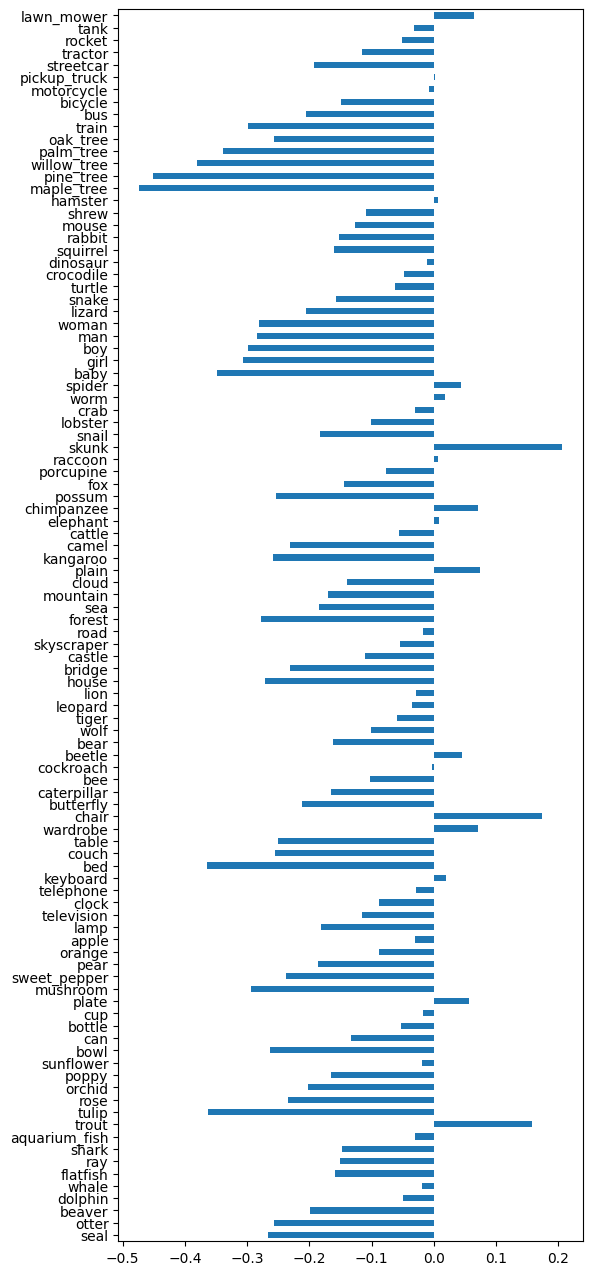

In [86]:
import pandas as pd

df = pd.DataFrame(
    {
     'label': F_label,
     'c_label': np.array([fine_to_coarse[i] for i in F_label]),
     'F_CF': F_precisions - CF_precisions,
     'F_C': F_precisions - C_precisions,
     'CF_C': CF_precisions - C_precisions,
    })

# График различия точности распознавания узкого класса и точности распознавания широкого класса по узкому
df.sort_values(by=['c_label', 'F_CF'],ascending=True).plot.barh(y='F_CF', x='label', legend=False, figsize=(6, 16), ylabel='')

График показывает различия точности распознавания узкого класса и точности распознавания широкого класса по узкому и позволяет сделать вывод, насколько точно определяется узкий класс в рамках широкого. Наибольший разброс имеют элементы широкого класса деревьев (trees) и людей (people), это говорит о том, что конкретный вид деревьев и людей между собой данная сеть определяет плохо. Наименьшее отклонение имеют следующие узкие классы lawn_mover, turtle, worm, plain, road, keyboard, telephone, plate, bottle, такие сеть определяет хорошо.


<AxesSubplot: >

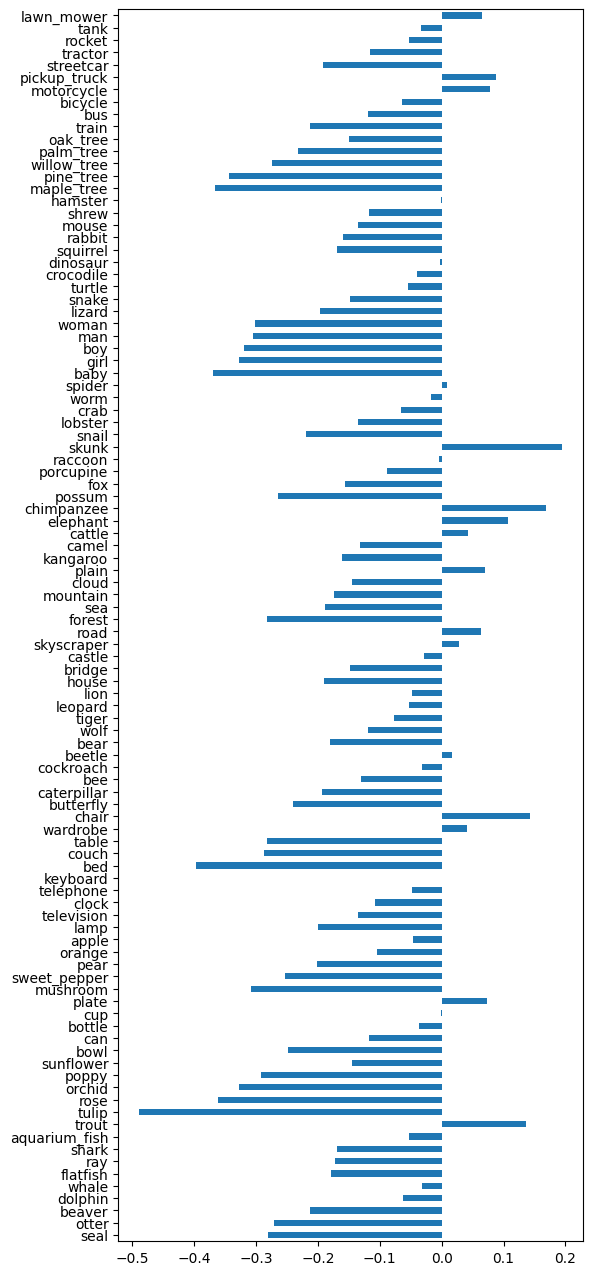

In [87]:
# График различия точности распознавания узкого класса и точности распознавания широкого класса
df.sort_values(by=['c_label', 'F_C'],ascending=True).plot.barh(y='F_C', x='label', legend=False, figsize=(6, 16), ylabel='')

График показывает различия точности распознавания узкого класса и точности распознавания широкого класса и позволяет сделать вывод о том, что модель определяет лучше широкие классы или узкие. Например, изображение сосны (pine_tree) в случае определения по широкому классу определяется лучше, чем по узкому. А изображения динозавра (dinosaur), дикообраза (porcupine), облака (cloud), дороги (road) определяются с примерно одинаковой точностью, как в случае распознавания по узкому классу, так и по широкому.


<AxesSubplot: >

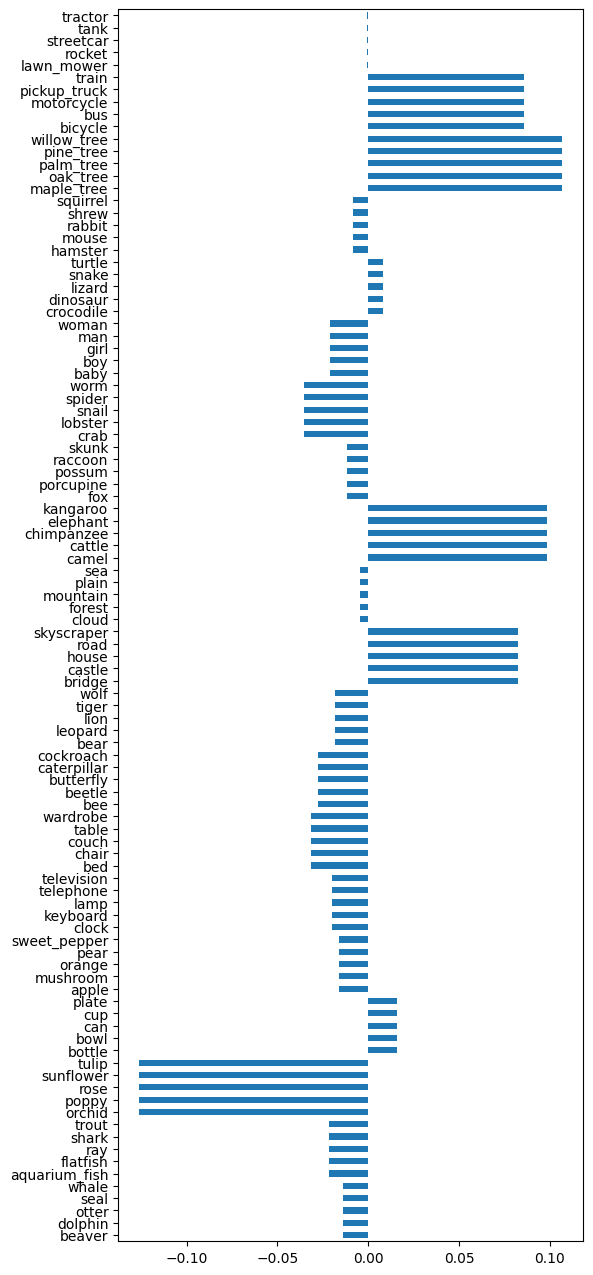

In [88]:
# График различия точности распознавания широкого класса по узкому и точности распознавания широкого класса
df.sort_values(by=['c_label', 'CF_C'],ascending=True).plot.barh(y='CF_C', x='label', legend=False, figsize=(6, 16), ylabel='')

График различия точности распознавания широкого класса по узкому и точности распознавания широкого класса позволяет сделать вывод о том, какие категории лучше определяются при обучении на узких классах, а какие на широких. На узких классах лучше определяются (имеют положительное значение на графике) транспортные средства (vehicles_2), деревья (trees), рептилии (reptiles), беспозвоночные ненасекомые(non-insect invertebrates), природа (large natural outdoor scenes), контейнеры для еды (food containers), водные млекопитающие (aquatic mammals) и пр.. Остальные классы лучше определяются при обучении на широких классах.
